In [65]:
import os
import numpy as np
import tensorflow as tf
from scipy.io import wavfile
import matplotlib.pyplot as plt

import librosa
import random
np.random.seed(0)

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, MaxPool1D
from keras.layers import Flatten, Dropout
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

In [66]:
tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

'./data/mini_speech_commands.zip'

In [67]:
!rm -rf data_set/
!unzip -q data/mini_speech_commands.zip -d data_set/ 

In [68]:
yes_ds_dir = 'data_set/mini_speech_commands/yes/'
no_ds_dir = 'data_set/mini_speech_commands/no/'
yes_wav = [f for f in os.listdir(yes_ds_dir) if f.endswith('.wav')]
no_wav = [f for f in os.listdir(no_ds_dir) if f.endswith('.wav')]
files_yes = []
files_no = []

for i in range(1000):
  files_yes.append(os.path.join(yes_ds_dir, yes_wav[i]))

for i in range(1000):
  files_no.append(os.path.join(no_ds_dir, no_wav[i]))

In [69]:
def model_maxpool(input_arr):
  input_arr =  input_arr.reshape(1, 725, 44) 
  max_pool = MaxPool1D(pool_size = 5, strides = 10)
  model = Sequential([max_pool]) 
  output = model.predict(input_arr)
  output = np.squeeze(output)
  return output 

In [70]:
dataset = []
label = []
yes_label = 1
no_label = 0

for i in range(len(files_yes)):
#for i in range(1):
  data, sr = librosa.load(files_yes[i])
  S = np.abs(librosa.stft(data))
  #print(type(S))
  if (S.shape)==(1025,44):
    S = S[:725,:]
    max_pool = model_maxpool(S)
    dataset.append(max_pool)
    label.append(yes_label)

for i in range(len(files_yes)):
#for i in range(1):
  data, sr = librosa.load(files_no[i])
  S = np.abs(librosa.stft(data))
  if (S.shape)==(1025,44):
    S = S[:725,:]
    max_pool = model_maxpool(S)
    #print(max_pool.shape)
    dataset.append(max_pool)
    label.append(no_label)

In [71]:
dataset = np.asarray(dataset)
label = np.asarray(label)

(1788, 73, 44)
(1788,)


In [72]:
test_data_yes =  dataset[0:50, :, :]
test_label_yes =  dataset[0:50]

X_train = dataset[50:1738, :, :]
y_train = label[50:1738] 

test_data_no = dataset[1738:1788, :, :]
test_label_no =  dataset[1738:1788]

(50, 73, 44)
(50, 73, 44)
(1688, 73, 44)
(1688,)


In [73]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (73,44)), "The dimensions of the images are not as expected"

In [75]:
def create_model():
    model = Sequential()
    model.add(Conv2D(1, kernel_size=(5,5),input_shape=(73, 44, 1), activation='elu'))
    model.add(Conv2D(1, kernel_size=(5,5), activation='elu'))
    model.add(Conv2D(1, kernel_size=(5,5), activation='elu'))
    model.add(Conv2D(1, kernel_size=(5,5), activation='elu'))
    model.add(Conv2D(1, kernel_size=(5,5), activation='elu'))
    model.add(MaxPooling2D(pool_size=(5, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='elu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(Adam(learning_rate=0.001),  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [76]:
model = create_model()
print(model.summary())

Model: "sequential_3578"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 69, 40, 1)         26        
                                                                 
 conv2d_11 (Conv2D)          (None, 65, 36, 1)         26        
                                                                 
 conv2d_12 (Conv2D)          (None, 61, 32, 1)         26        
                                                                 
 conv2d_13 (Conv2D)          (None, 57, 28, 1)         26        
                                                                 
 conv2d_14 (Conv2D)          (None, 53, 24, 1)         26        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 12, 1)        0         
 2D)                                                             
                                                   

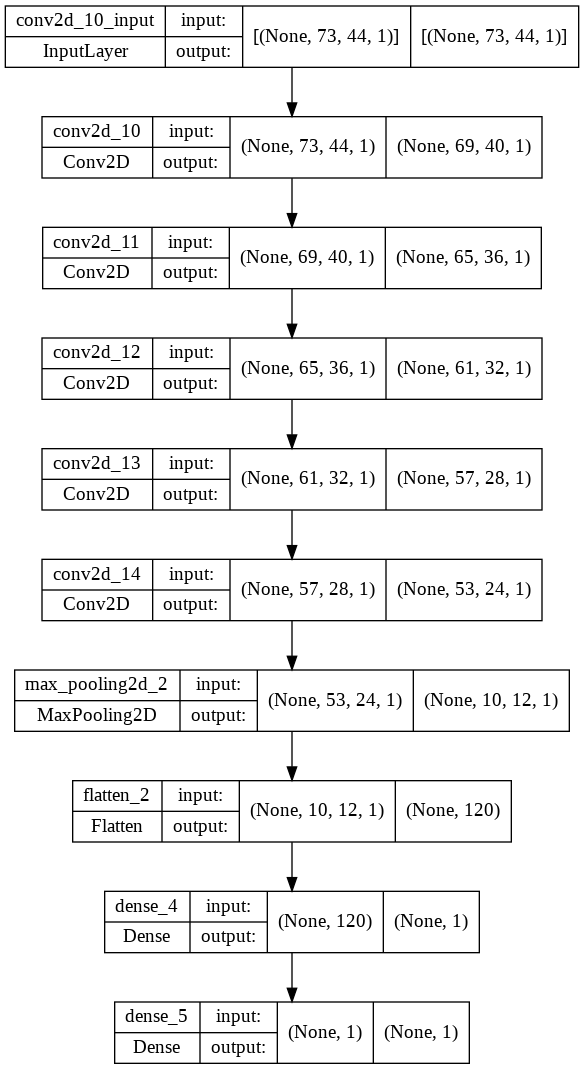

In [77]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [78]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs = 25, batch_size = 12, verbose = 1, shuffle = 1)

Epoch 1/25
113/113 [==============================] - 1s 7ms/step - loss: 0.6865 - accuracy: 0.6156 - val_loss: 0.7309 - val_accuracy: 0.0385
Epoch 2/25
113/113 [==============================] - 1s 6ms/step - loss: 0.5840 - accuracy: 0.8519 - val_loss: 0.4399 - val_accuracy: 0.8107
Epoch 3/25
113/113 [==============================] - 1s 5ms/step - loss: 0.4879 - accuracy: 0.8837 - val_loss: 0.3279 - val_accuracy: 0.8757
Epoch 4/25
113/113 [==============================] - 1s 5ms/step - loss: 0.4356 - accuracy: 0.8956 - val_loss: 0.3385 - val_accuracy: 0.8373
Epoch 5/25
113/113 [==============================] - 1s 5ms/step - loss: 0.3908 - accuracy: 0.9133 - val_loss: 0.2797 - val_accuracy: 0.8698
Epoch 6/25
113/113 [==============================] - 1s 5ms/step - loss: 0.3547 - accuracy: 0.9259 - val_loss: 0.2311 - val_accuracy: 0.8905
Epoch 7/25
113/113 [==============================] - 1s 5ms/step - loss: 0.3309 - accuracy: 0.9244 - val_loss: 0.1710 - val_accuracy: 0.9349
Epoch 

Text(0.5, 0, 'epoch')

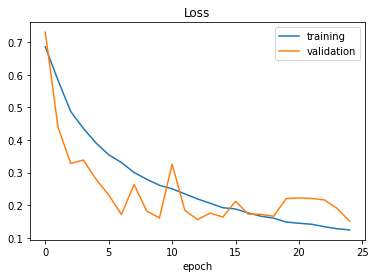

In [79]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

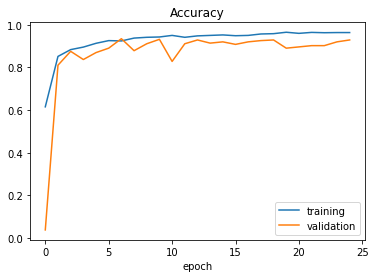

In [80]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [82]:
weights = model.get_weights()

14


In [84]:
Layer1_Conv2D_5x5 = np.asarray(weights[0][:,:])
Bais_L1 = np.asarray(weights[1])
Layer2_Conv2D_5x5 = np.asarray(weights[2][:])
Bais_L2 = np.asarray(weights[3])
Layer3_Conv2D_5x5 = np.asarray(weights[4][:,:])
Bais_L3 = np.asarray(weights[5])
Layer4_Conv2D_5x5 = np.asarray(weights[6][:])
Bais_L4 = np.asarray(weights[7])
Layer5_Conv2D_5x5 = np.asarray(weights[8][:,:])
Bais_L5 = np.asarray(weights[9])
#Flatten 30*3 to 90
Layer7_Dense = np.asarray(weights[10])
Bais_L7 = np.asarray(weights[11])
Layer8_SoftMax = np.asarray(weights[12])
Bais_L8 = np.asarray(weights[13])

(120, 1)


In [85]:
# Flatten Audio data for yes and no
audiodata_yes = audiodata_yes.flatten()

#Layer1 Conv2D layer weights
L1K = Layer1_Conv2D_5x5[:,:,0,0].flatten()
L2K = Layer2_Conv2D_5x5[:,:,0,0].flatten()
L3K = Layer3_Conv2D_5x5[:,:,0,0].flatten()
L4K = Layer4_Conv2D_5x5[:,:,0,0].flatten()
L5K = Layer5_Conv2D_5x5[:,:,0,0].flatten()

L7W = Layer7_Dense[:,:].flatten()
L8W = Layer8_SoftMax[:,0].flatten()

(3212,)
(1,)


In [86]:
temp1 = np.append(L1K, Bais_L1)
temp2 = np.append(L2K, Bais_L2)
temp3 = np.append(L3K, Bais_L3)
temp4 = np.append(L4K, Bais_L4)
temp5 = np.append(L5K, Bais_L5)
temp7 = np.append(L7W, Bais_L7.flatten())
temp8 = np.append(L8W, Bais_L8)


temp12 = np.append(temp1, temp2)
temp34 = np.append(temp3, temp4)
temp57 = np.append(temp5, temp7)
temp1234 = np.append(temp12, temp34)
temp = np.append(temp1234, temp57)
weights = np.append(temp, temp8)

print(weights.shape)

(253,)


In [88]:
# Open weight and bias files for reading.
f_handle = open('weights.bin','w')
weights.tofile(f_handle,sep="")

In [91]:
!rm -rf test_data_yes/
!rm -rf test_data_no/

In [92]:
!mkdir test_data_yes/
!mkdir test_data_no/

In [93]:
for iter in range (50):
  audiof_handle_yes = open('test_data_yes/' + 'data' + str(iter) + '.bin','w')
  data_yes = test_data_yes[iter, :,:]
  data_yes.tofile(audiof_handle_yes,sep="")

  audiof_handle_no = open('test_data_no/' + 'data' + str(iter) + '.bin','w')
  data_no = test_data_no[iter, :,:]
  data_no.tofile(audiof_handle_no,sep="")


In [94]:
!zip -r test_data_yes.zip test_data_yes/
!zip -r test_data_no.zip test_data_no/

updating: test_data_yes/ (stored 0%)
updating: test_data_yes/data29.bin (deflated 7%)
updating: test_data_yes/data36.bin (deflated 7%)
updating: test_data_yes/data43.bin (deflated 6%)
updating: test_data_yes/data12.bin (deflated 7%)
updating: test_data_yes/data35.bin (deflated 6%)
updating: test_data_yes/data22.bin (deflated 7%)
updating: test_data_yes/data40.bin (deflated 8%)
updating: test_data_yes/data48.bin (deflated 8%)
updating: test_data_yes/data3.bin (deflated 7%)
updating: test_data_yes/data37.bin (deflated 8%)
updating: test_data_yes/data33.bin (deflated 6%)
updating: test_data_yes/data39.bin (deflated 7%)
updating: test_data_yes/data18.bin (deflated 6%)
updating: test_data_yes/data20.bin (deflated 7%)
updating: test_data_yes/data4.bin (deflated 8%)
updating: test_data_yes/data34.bin (deflated 7%)
updating: test_data_yes/data10.bin (deflated 7%)
updating: test_data_yes/data41.bin (deflated 8%)
updating: test_data_yes/data24.bin (deflated 7%)
updating: test_data_yes/data2.bin 

In [96]:
results = model.predict(test_data_yes)
print(len(results))
for i in range (len(results)):
  if(results[i] < 0.5):
    print("Predicted Audio: NO with accuracy:"+str((1-results[i]) * 100))
    print("Wrong")

50
Predicted Audio: NO with accuracy:[71.65349]
Wrong
Predicted Audio: NO with accuracy:[54.55623]
Wrong
Predicted Audio: NO with accuracy:[67.74868]
Wrong
Predicted Audio: NO with accuracy:[55.335533]
Wrong
Predicted Audio: NO with accuracy:[73.219894]
Wrong


In [97]:
print(results)

[[0.93165016]
 [0.93180573]
 [0.9318055 ]
 [0.93180573]
 [0.93180543]
 [0.93141896]
 [0.93176514]
 [0.28346512]
 [0.7465985 ]
 [0.75999516]
 [0.93180573]
 [0.93180573]
 [0.93180573]
 [0.9317488 ]
 [0.93160796]
 [0.9318056 ]
 [0.931462  ]
 [0.9317497 ]
 [0.93180573]
 [0.93180573]
 [0.93180573]
 [0.8350696 ]
 [0.93180573]
 [0.93129385]
 [0.93180573]
 [0.9316501 ]
 [0.93180573]
 [0.9317937 ]
 [0.9293186 ]
 [0.93175864]
 [0.93180573]
 [0.9318056 ]
 [0.93180573]
 [0.93180573]
 [0.9318056 ]
 [0.93180573]
 [0.93180573]
 [0.9318019 ]
 [0.9297834 ]
 [0.45443773]
 [0.9317848 ]
 [0.32251322]
 [0.9318055 ]
 [0.93180573]
 [0.93180573]
 [0.44664463]
 [0.9318055 ]
 [0.51942563]
 [0.26780102]
 [0.73958844]]


In [98]:
results = model.predict(test_data_no)
print(len(results))
for i in range (len(results)):
  if(results[i] > 0.5):
    print("Predicted Audio: YES with accuracy:"+str(results[i] * 100))
    print("Wrong")

50
Predicted Audio: YES with accuracy:[80.6185]
Wrong
Predicted Audio: YES with accuracy:[59.177486]
Wrong
Predicted Audio: YES with accuracy:[88.2534]
Wrong
Predicted Audio: YES with accuracy:[92.23678]
Wrong
Predicted Audio: YES with accuracy:[67.21678]
Wrong


In [99]:
print(results)

[[3.40024385e-21]
 [4.20584438e-05]
 [1.64905967e-09]
 [9.57539513e-16]
 [1.48018571e-02]
 [1.33699737e-03]
 [1.96932306e-04]
 [1.07544649e-04]
 [9.83660226e-04]
 [6.03410532e-04]
 [1.97364925e-03]
 [6.88173486e-07]
 [2.14921965e-04]
 [5.94621636e-02]
 [7.31725891e-07]
 [8.70426886e-13]
 [8.06185007e-01]
 [1.72279857e-03]
 [5.33573775e-11]
 [2.10554950e-04]
 [2.56591146e-12]
 [7.12987676e-04]
 [9.53592871e-10]
 [4.38358017e-10]
 [7.14648934e-03]
 [5.91774881e-01]
 [6.09682029e-05]
 [3.92519355e-01]
 [8.82534027e-01]
 [5.04789234e-04]
 [1.77286584e-02]
 [1.52982480e-04]
 [7.03716604e-03]
 [7.64146680e-05]
 [1.17240241e-02]
 [7.86819961e-03]
 [7.89055079e-02]
 [1.92137156e-03]
 [7.62463510e-02]
 [1.59345969e-16]
 [9.22367811e-01]
 [2.23747207e-04]
 [3.70660494e-03]
 [6.72167778e-01]
 [1.47853825e-05]
 [4.42985648e-11]
 [2.90215686e-02]
 [1.37691381e-06]
 [3.17274607e-09]
 [2.56849395e-04]]


In [101]:
model.save('audioclassifier.h5')